Test: 0.5, gamma value: -1.0


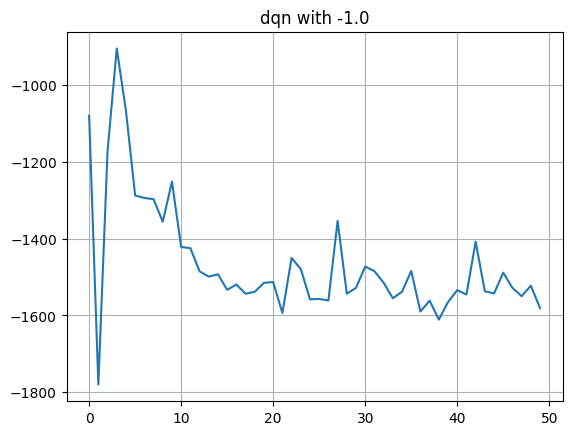

Test: 1.0, gamma value: 0.0


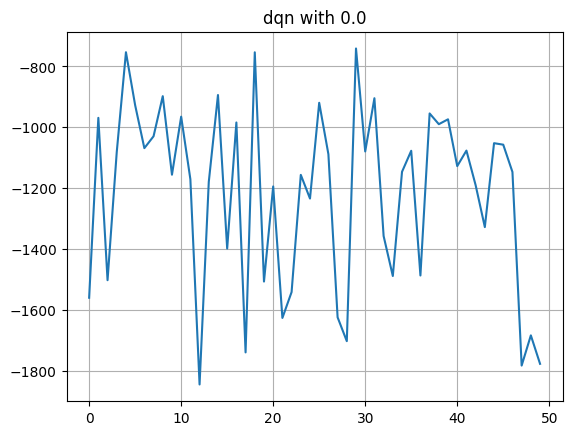

Test: 1.5, gamma value: 0.33333333333333337


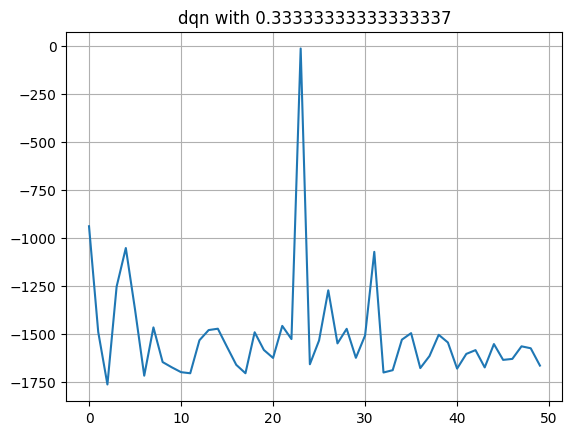

Test: 2.0, gamma value: 0.5


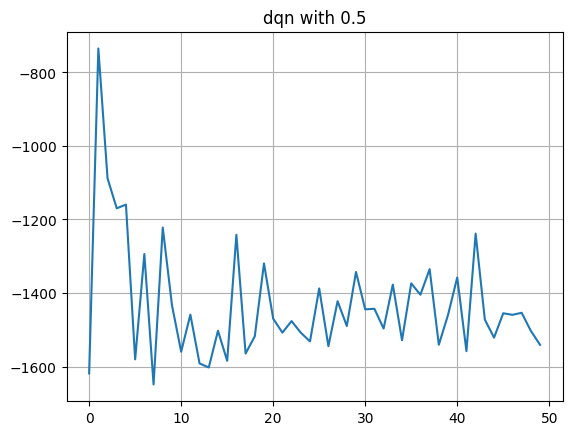

Test: 2.5, gamma value: 0.6


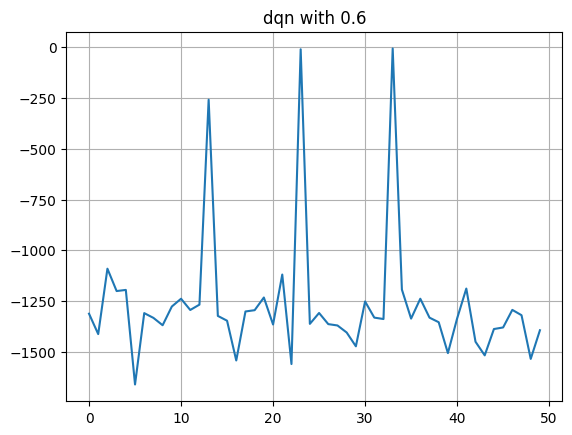

Test: 3.0, gamma value: 0.6666666666666667


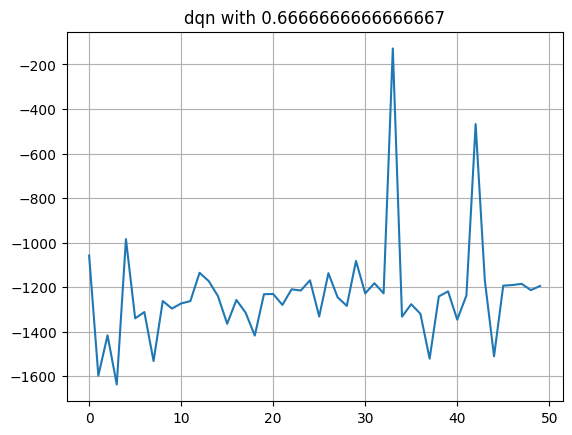

Test: 3.5, gamma value: 0.7142857142857143


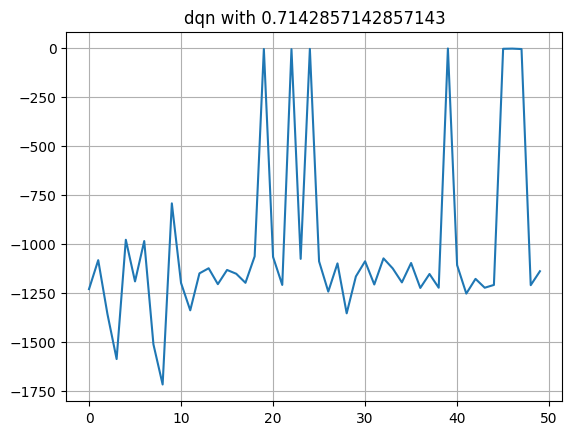

Test: 4.0, gamma value: 0.75


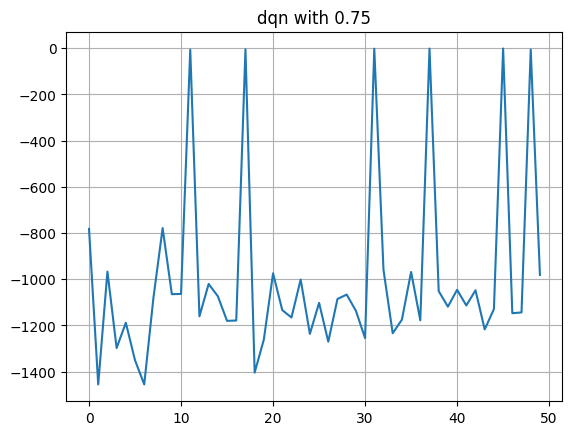

Test: 4.5, gamma value: 0.7777777777777778


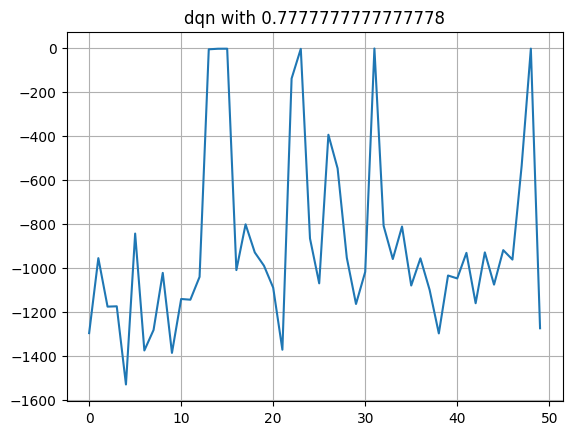

Test: 5.0, gamma value: 0.8


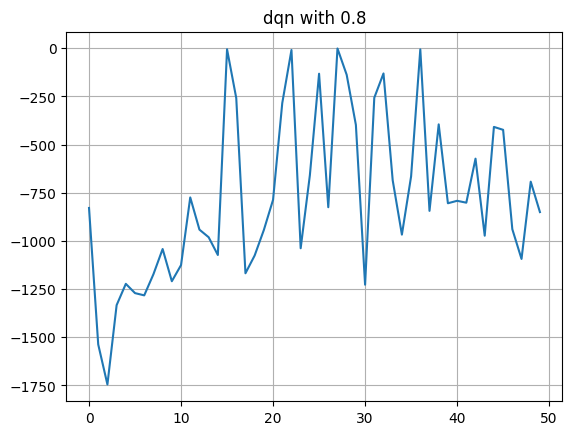

Test: 5.5, gamma value: 0.8181818181818181


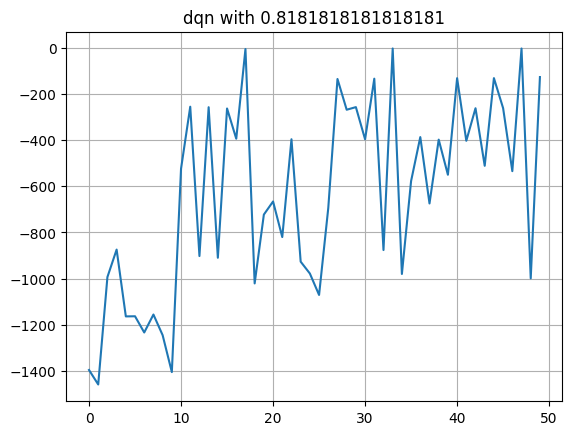

Test: 6.0, gamma value: 0.8333333333333334


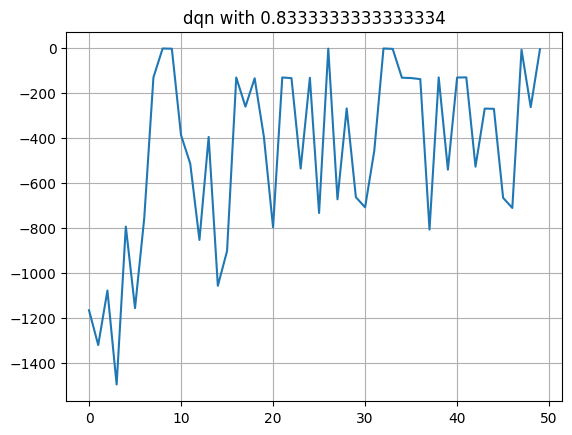

Test: 6.5, gamma value: 0.8461538461538461


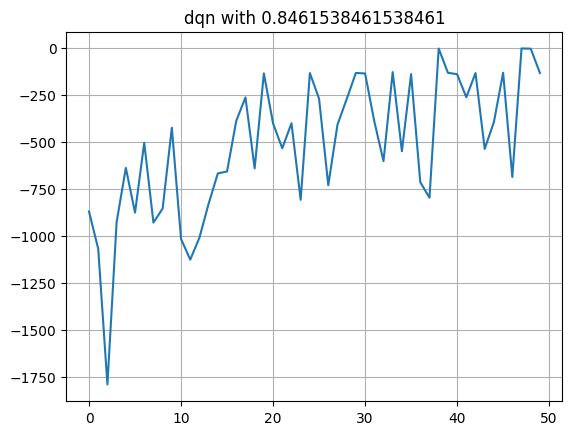

Test: 7.0, gamma value: 0.8571428571428572


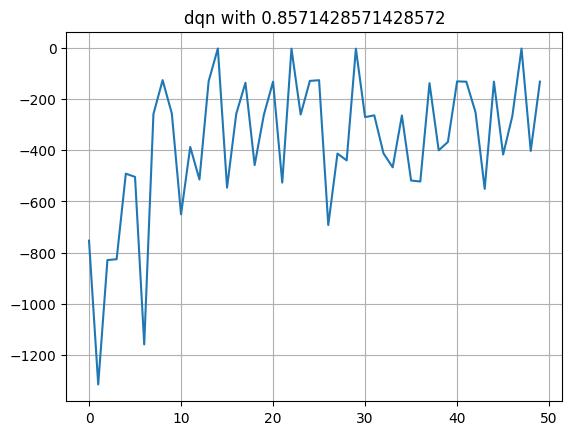

Test: 7.5, gamma value: 0.8666666666666667


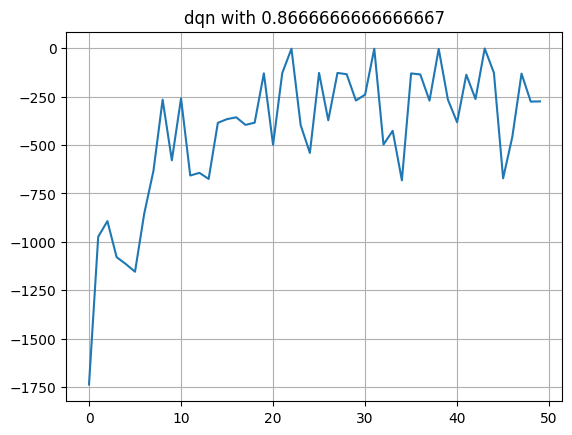

Test: 8.0, gamma value: 0.875


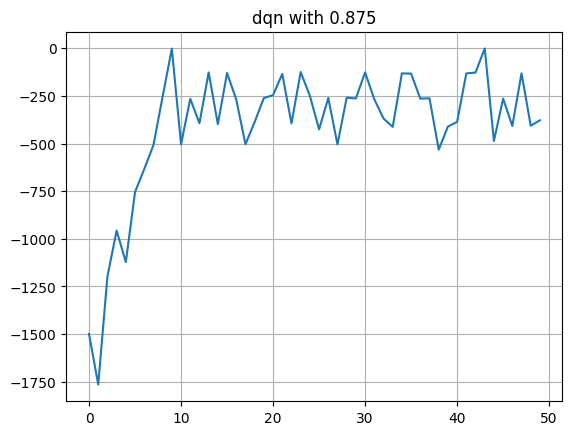

Test: 8.5, gamma value: 0.8823529411764706


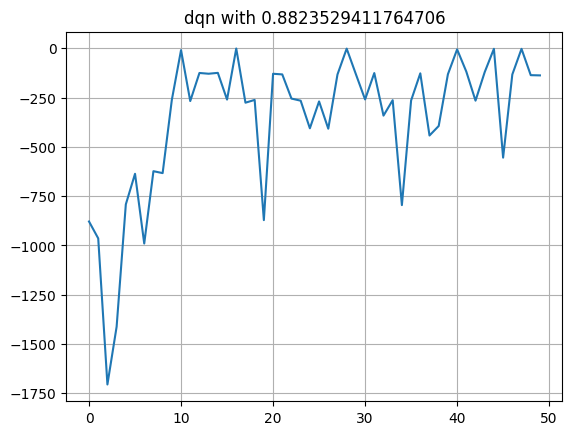

Test: 9.0, gamma value: 0.8888888888888888


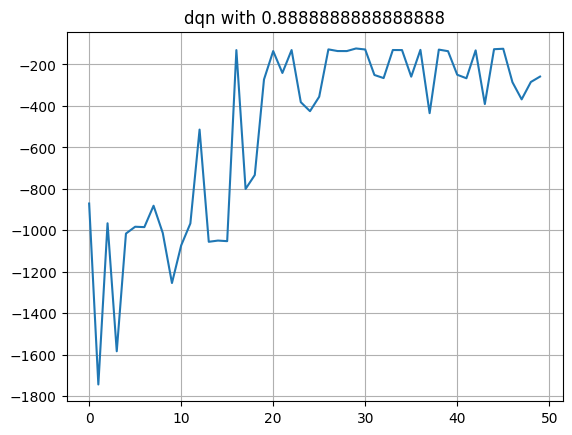

Test: 9.5, gamma value: 0.8947368421052632


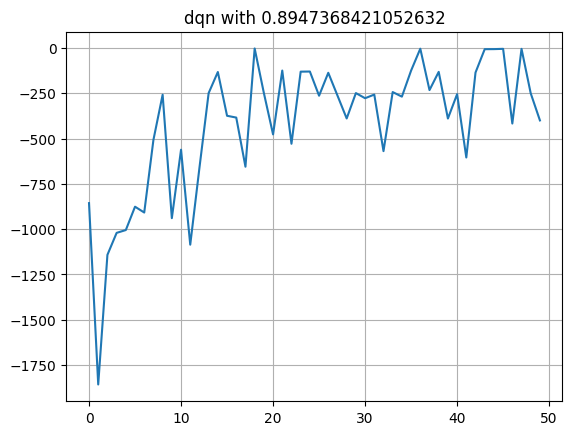

Test: 10.0, gamma value: 0.9


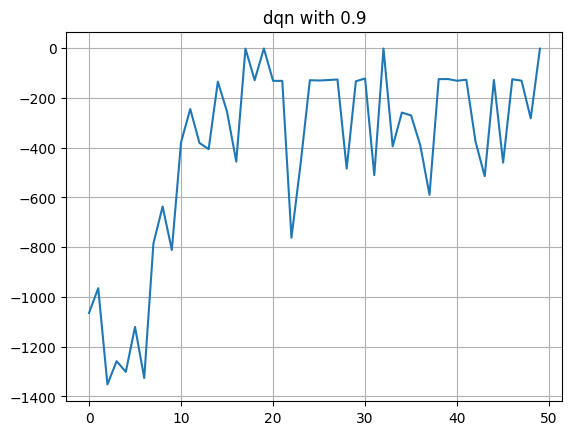

Test: 10.5, gamma value: 0.9047619047619048


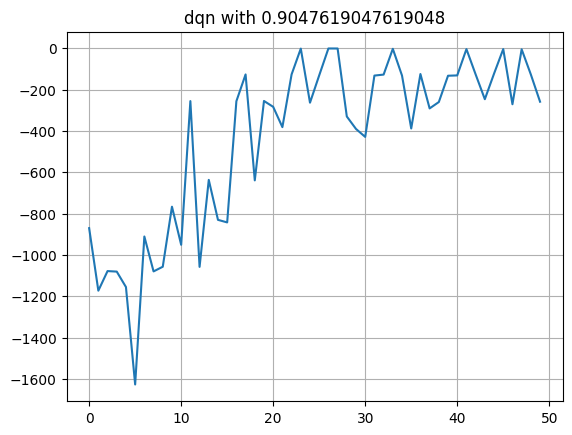

Test: 11.0, gamma value: 0.9090909090909091


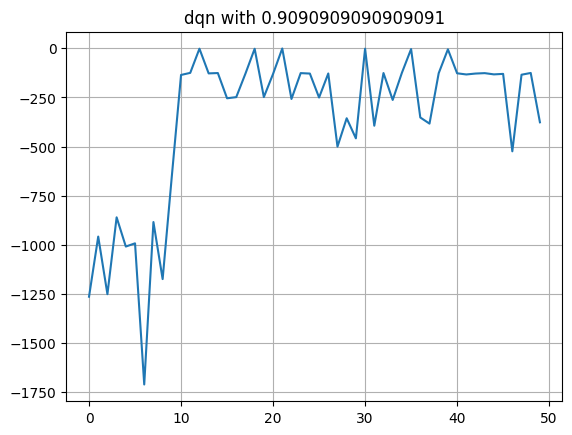

Test: 11.5, gamma value: 0.9130434782608696


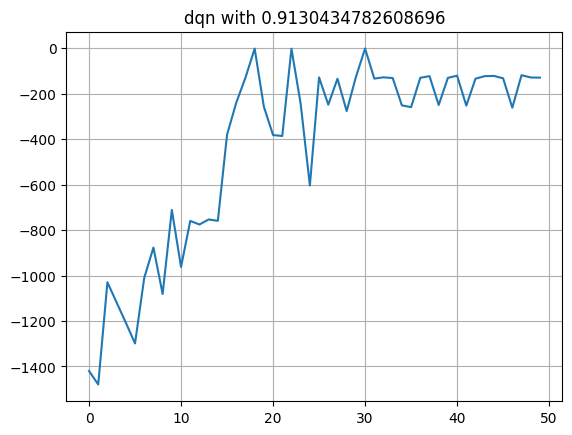

Test: 12.0, gamma value: 0.9166666666666666


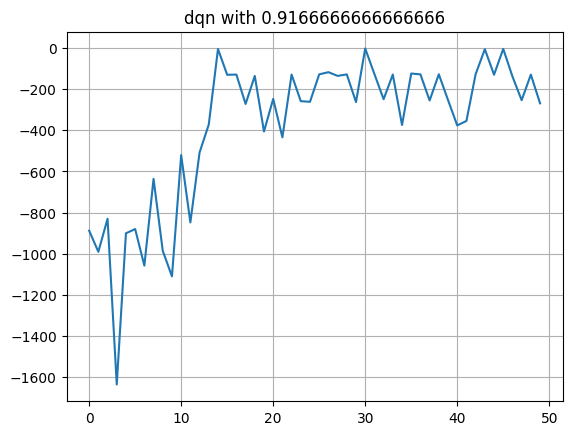

Test: 12.5, gamma value: 0.92


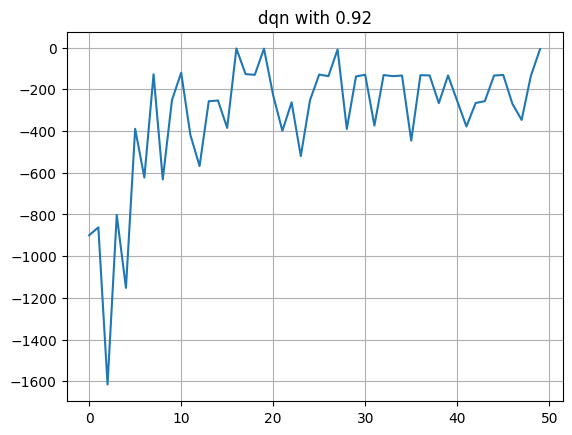

Test: 13.0, gamma value: 0.9230769230769231


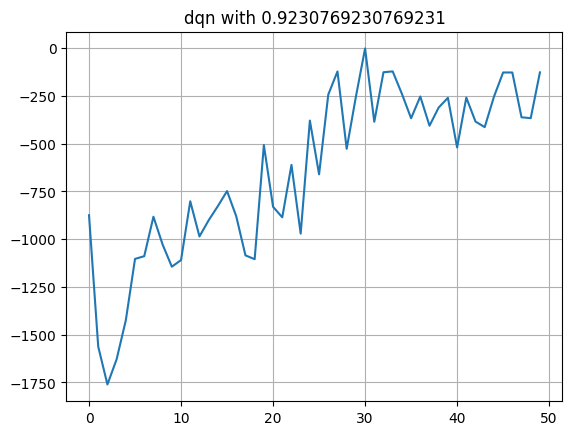

Test: 13.5, gamma value: 0.9259259259259259


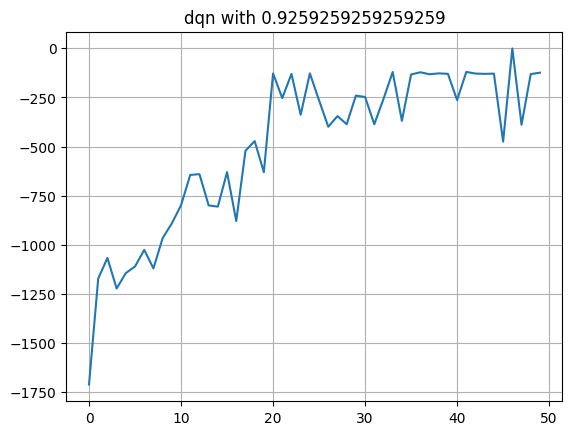

Test: 14.0, gamma value: 0.9285714285714286


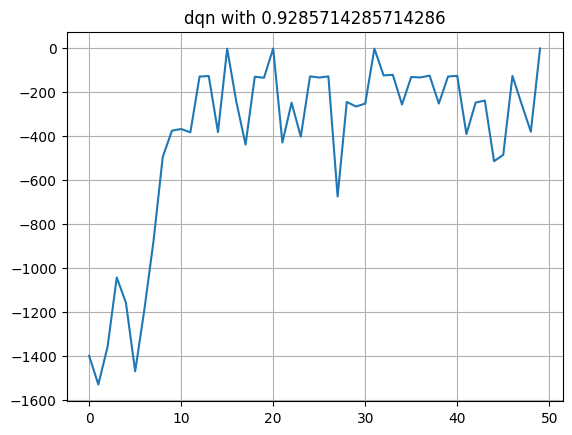

Test: 14.5, gamma value: 0.9310344827586207


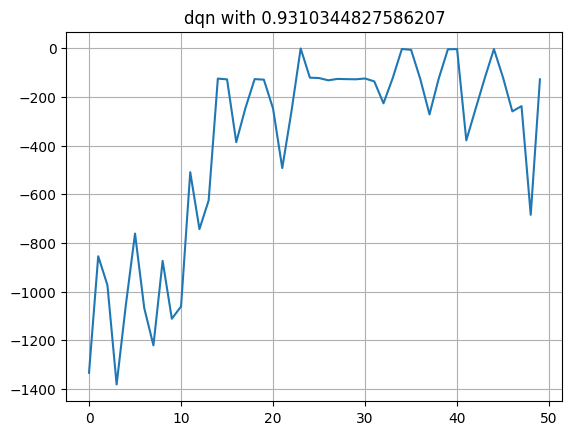

Test: 15.0, gamma value: 0.9333333333333333


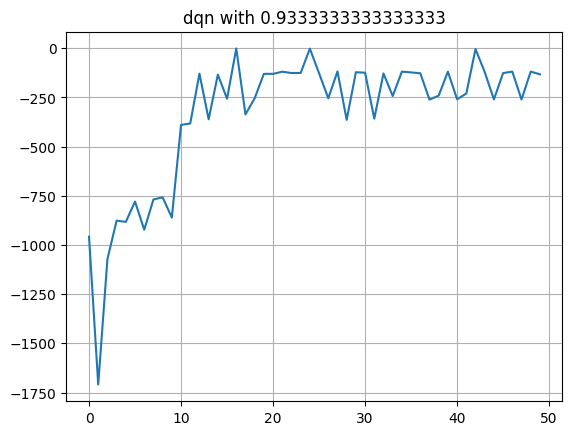

Test: 15.5, gamma value: 0.935483870967742


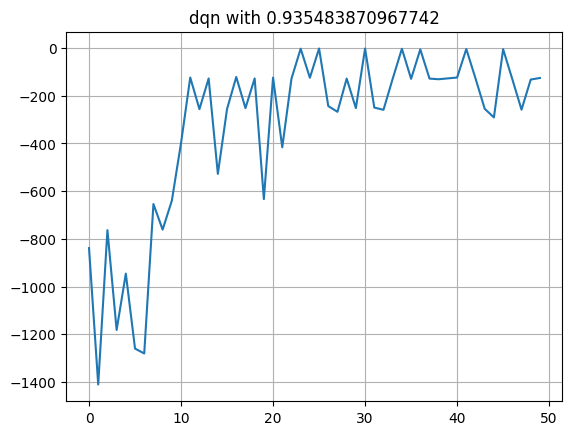

Test: 16.0, gamma value: 0.9375


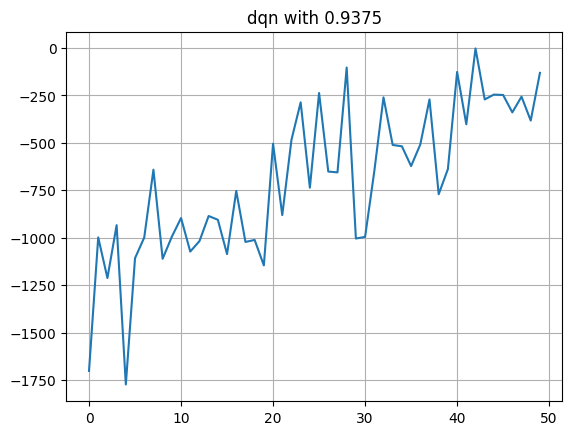

Test: 16.5, gamma value: 0.9393939393939394


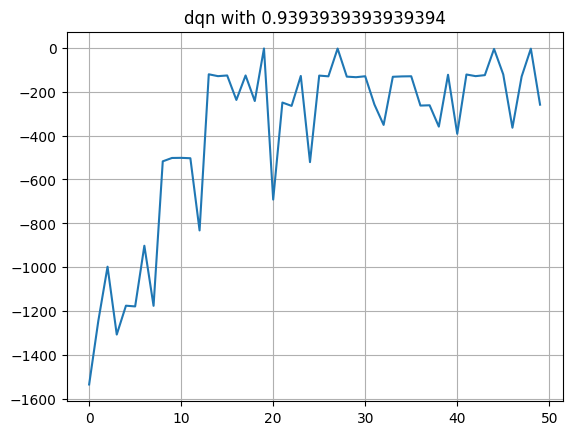

Test: 17.0, gamma value: 0.9411764705882353


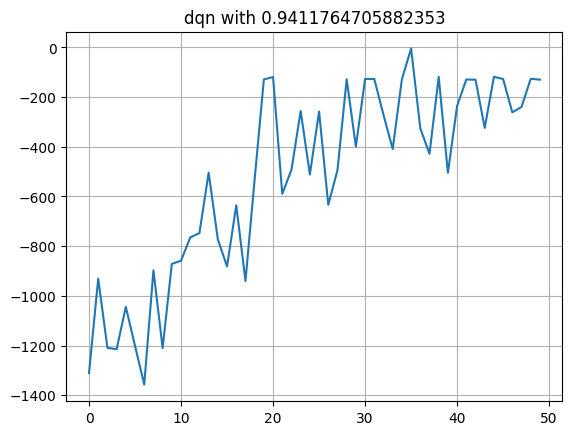

Test: 17.5, gamma value: 0.9428571428571428


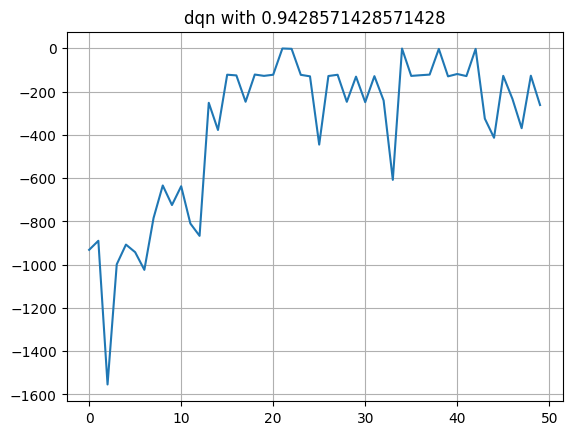

Test: 18.0, gamma value: 0.9444444444444444


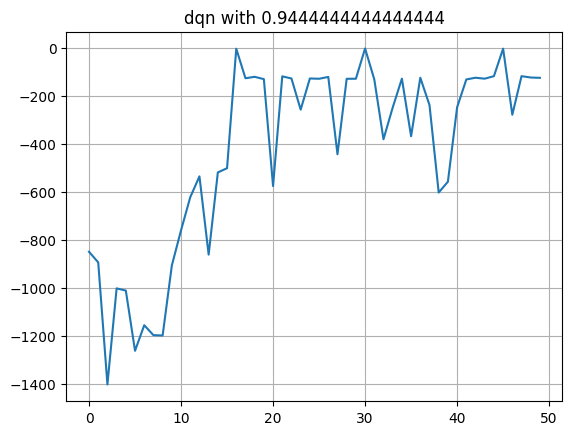

Test: 18.5, gamma value: 0.9459459459459459


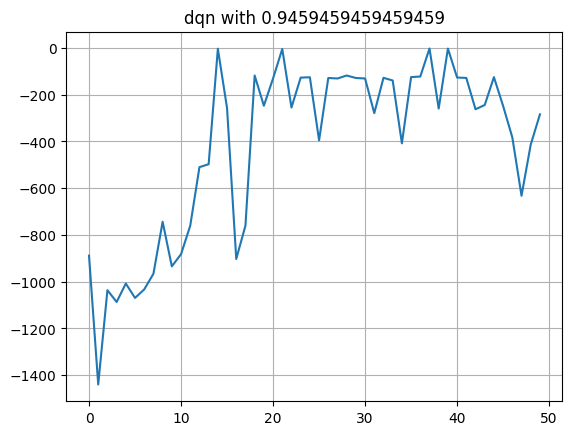

Test: 19.0, gamma value: 0.9473684210526316


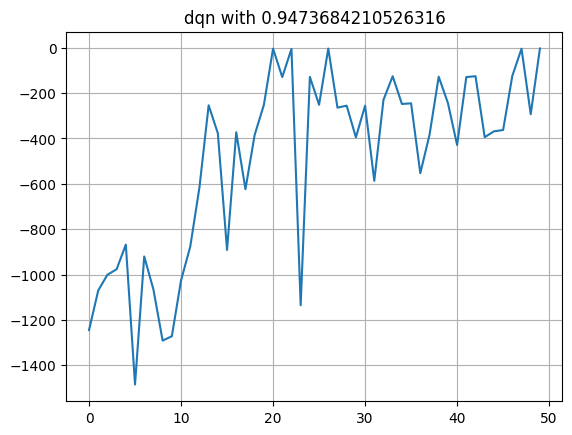

Test: 19.5, gamma value: 0.9487179487179487


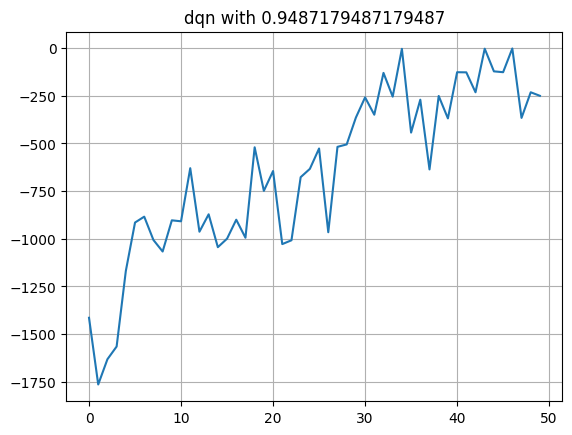

Test: 20.0, gamma value: 0.95


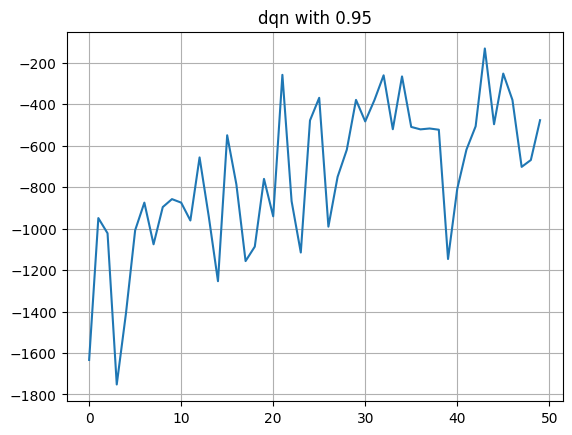

Test: 20.5, gamma value: 0.9512195121951219


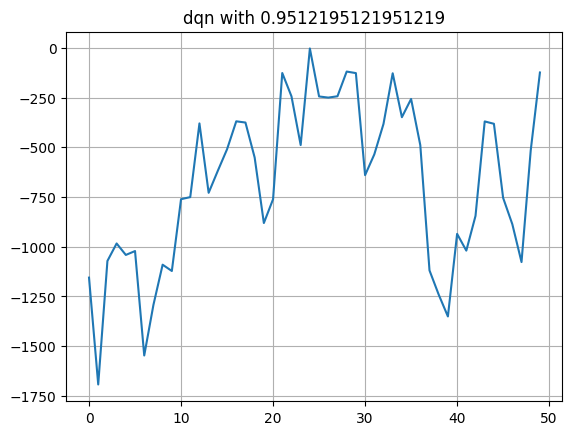

Test: 21.0, gamma value: 0.9523809523809523


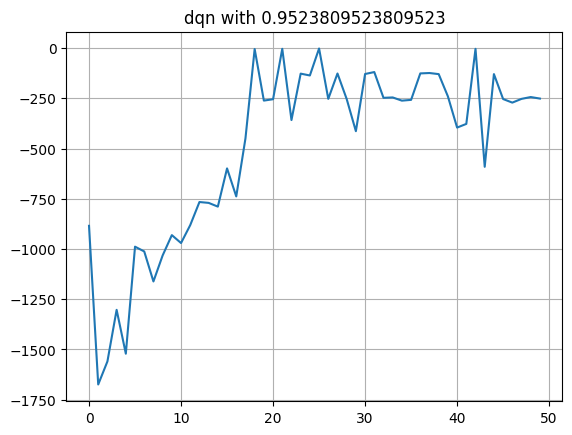

Test: 21.5, gamma value: 0.9534883720930233


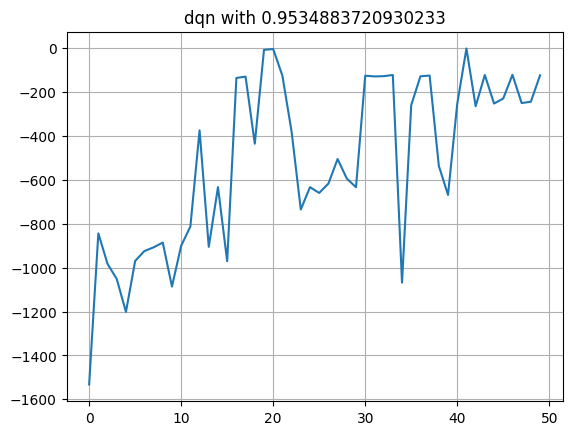

Test: 22.0, gamma value: 0.9545454545454546


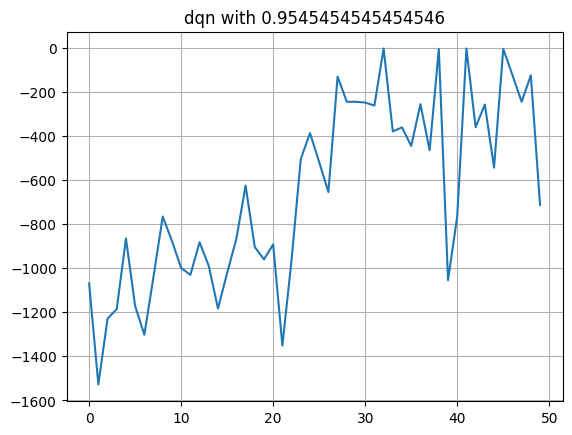

Test: 22.5, gamma value: 0.9555555555555556


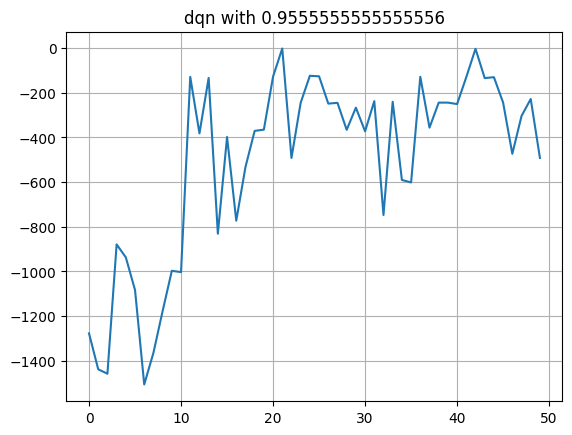

Test: 23.0, gamma value: 0.9565217391304348


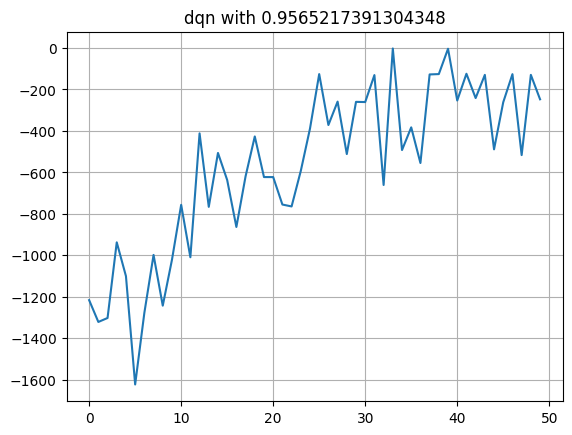

Test: 23.5, gamma value: 0.9574468085106383


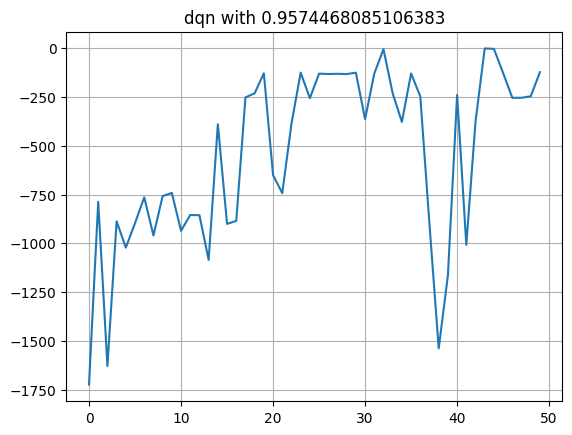

Test: 24.0, gamma value: 0.9583333333333334


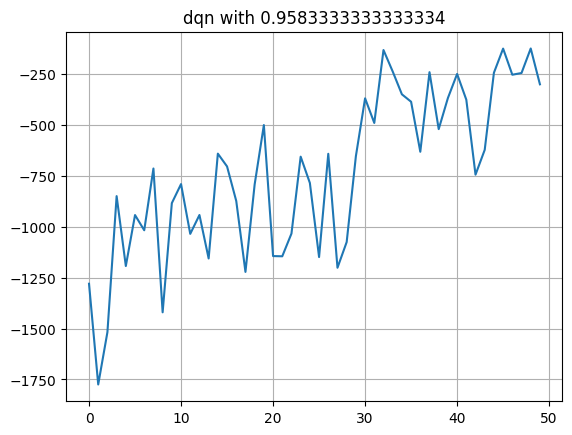

Test: 24.5, gamma value: 0.9591836734693877


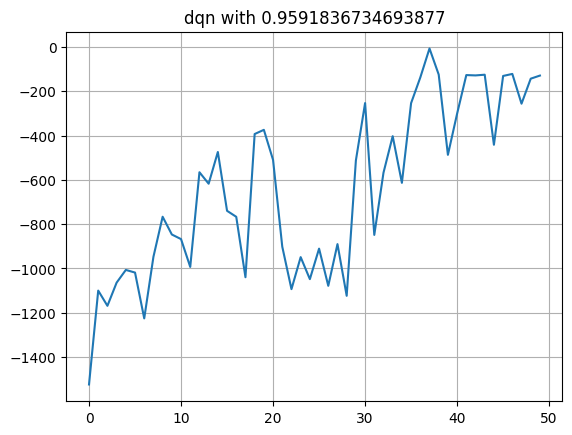

Test: 25.0, gamma value: 0.96


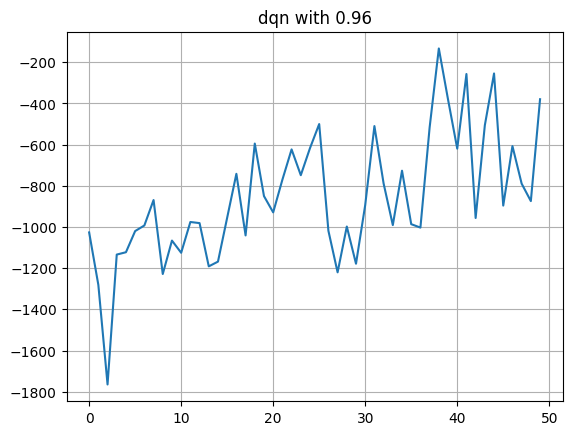

Test: 25.5, gamma value: 0.9607843137254902


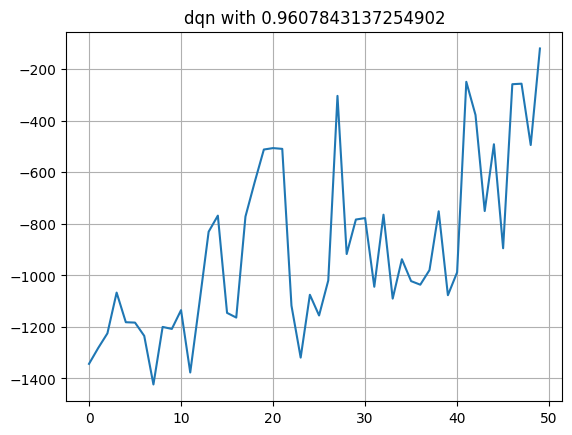

Test: 26.0, gamma value: 0.9615384615384616


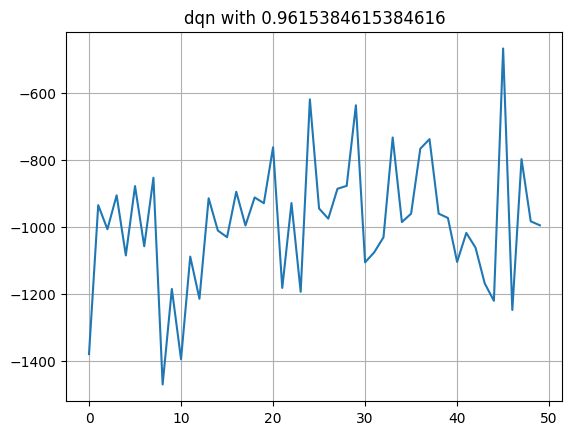

Test: 26.5, gamma value: 0.9622641509433962


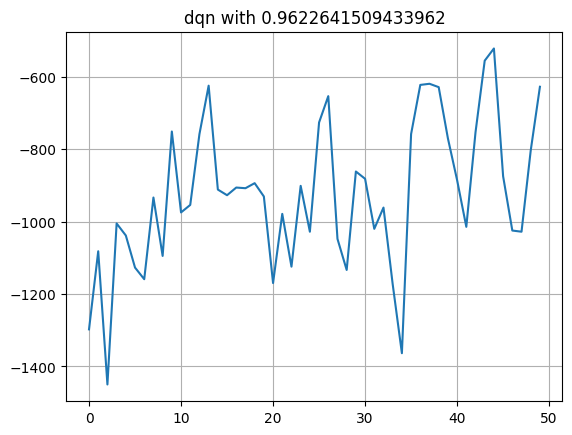

Test: 27.0, gamma value: 0.962962962962963


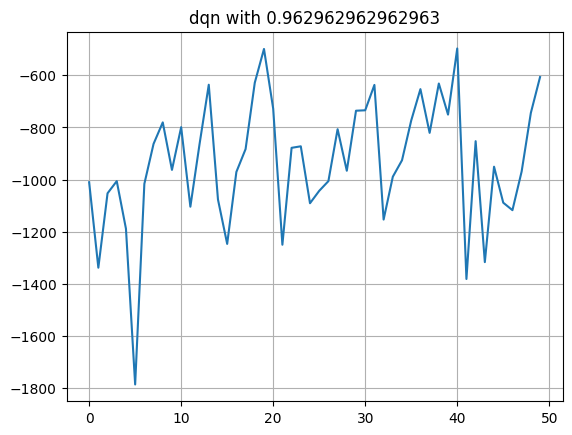

Test: 27.5, gamma value: 0.9636363636363636


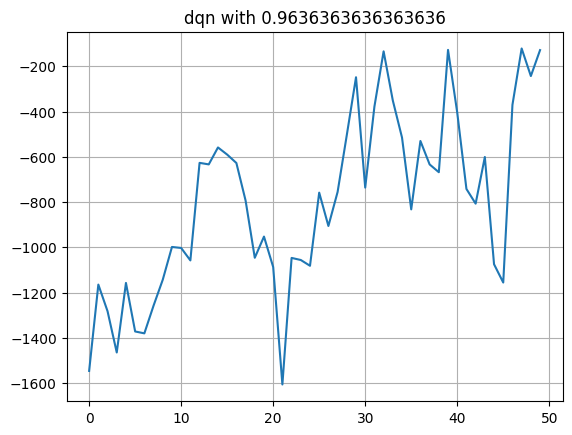

Test: 28.0, gamma value: 0.9642857142857143


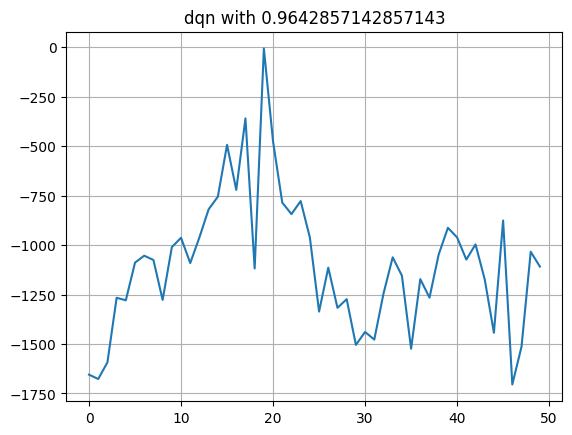

Test: 28.5, gamma value: 0.9649122807017544


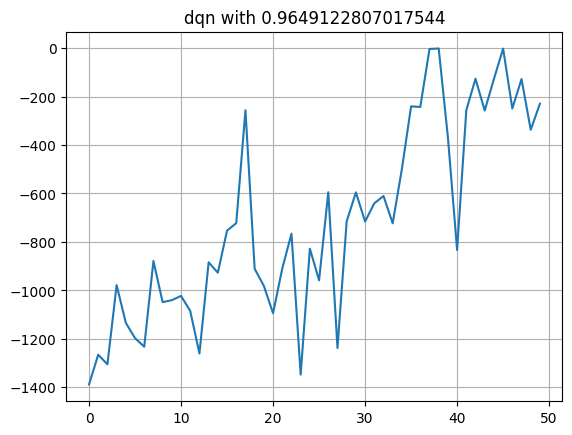

Test: 29.0, gamma value: 0.9655172413793104


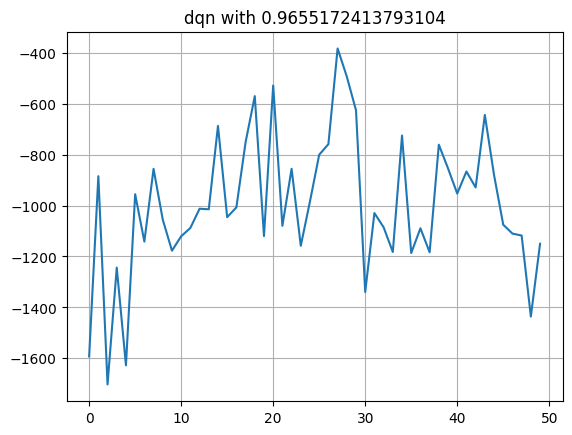

Test: 29.5, gamma value: 0.9661016949152542


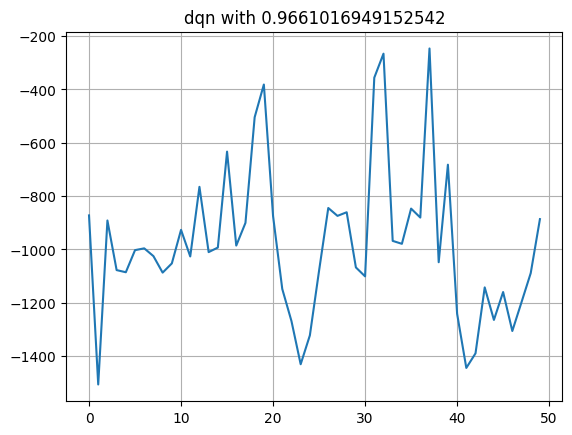

Test: 30.0, gamma value: 0.9666666666666667


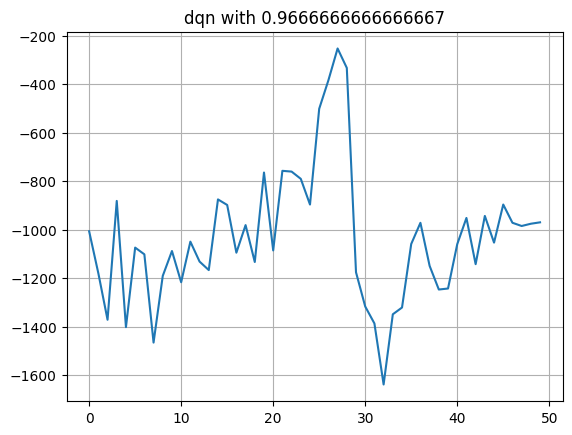

In [1]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the action transformation function
def transform_action_values(n_actions, min_action=-2.0, max_action=2.0):
    linear_actions = np.linspace(-1, 1, n_actions)
    non_linear_actions = np.sign(linear_actions) * (linear_actions ** 2)
    scaled_actions = min_action + (non_linear_actions + 1) * (max_action - min_action) / 2
    return scaled_actions

# Define the Replay Buffer class
class ReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        states, actions, rewards, next_states, dones = zip(*mini_batch)

        # Convert lists of arrays/tensors to tensors
        states = torch.stack([torch.tensor(s, dtype=torch.float32).to(device) for s in states])
        actions = torch.tensor(actions, dtype=torch.float32).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
        next_states = torch.stack([torch.tensor(s, dtype=torch.float32).to(device) for s in next_states])
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

        return states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)


    def size(self):
        return len(self.buffer)

# Define the Q-Network class
class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

class Agent:
    def __init__(self, state_size, action_size, gamma_epoch):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(1000000)
        self.batch_size = 256
        self.gamma = (1-(1/gamma_epoch))
        self.epsilon = 1
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.001
        self.learning_rate = 0.005
        self.model = DQNNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.action_values = transform_action_values(action_size)

    def select_action(self, state_tensor):
        if np.random.rand() > self.epsilon:
            action_index = torch.argmax(self.model(state_tensor)).item()
            action = self.action_values[action_index]
        else:
            action_index = np.random.randint(len(self.action_values))
            action = self.action_values[action_index]
        return action, action_index

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.put((state, action, reward, next_state, done))

    def train_agent(self):
        if self.memory.size() < self.batch_size:
            return

        s_batch, a_batch, r_batch, s_prime_batch, done_batch = self.memory.sample(self.batch_size)

        s_batch = s_batch.to(device)
        a_batch = a_batch.to(device)
        r_batch = r_batch.to(device)
        s_prime_batch = s_prime_batch.to(device)
        done_batch = done_batch.to(device)

        # Convert action indices to long type for gather
        a_batch = a_batch.long()

        q_values = self.model(s_batch).gather(1, a_batch)
        next_q_values = self.model(s_prime_batch).detach().max(1)[0].unsqueeze(1)
        expected_q_values = r_batch + self.gamma * next_q_values * (1 - done_batch)

        loss = F.smooth_l1_loss(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

# Main training loop
if __name__ == "__main__":
    average_score = {}
    for i in range(60):
        number = (i*0.5)+0.5

        env = gym.make('Pendulum-v1')
        state_size = env.observation_space.shape[0]
        action_size = 11

        agent = Agent(state_size, action_size, gamma_epoch=number)

        EPOCHS = 50
        score_list = []

        for EP in range(EPOCHS):
            state, info = env.reset()
            score = 0
            done = False

            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                action, action_index = agent.select_action(state_tensor)
                next_state, reward, done, truncated, _ = env.step([action])
                if done or truncated:
                    done = True
                agent.store_experience(state, action_index, reward, next_state, done)
                agent.train_agent()
                state = next_state
                score += reward

            score_list.append(score)
            # print(f"Episodes {EP + 1}/{EPOCHS}, Score: {score}, Epsilon: {agent.epsilon}")

        print(f"Test: {number}, gamma value: {agent.gamma}")
        last_ten = score_list[-15:]
        average_score[number] = (sum(last_ten) / len(last_ten))
        plt.plot(score_list)
        plt.grid(True)
        plt.title(f"dqn with {agent.gamma}")
        plt.savefig(f'dqn_plot/gamma({agent.gamma}).png')
        plt.show()

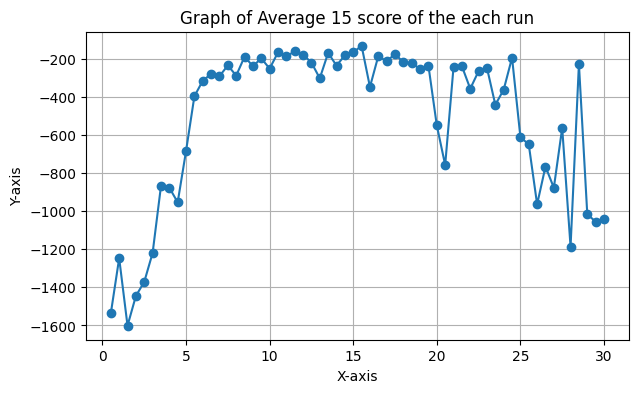

In [7]:
plt.figure(figsize=(7, 4))
plt.plot(average_score.keys(), average_score.values(), marker='o')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Graph of Average 15 score of the each run')
plt.grid(True)
plt.show()

In [3]:
print(average_score)

{0.5: -1536.634977747708, 1.0: -1246.8413311735721, 1.5: -1601.2395932562008, 2.0: -1444.9013372825991, 2.5: -1371.0473101767925, 3.0: -1219.518942303618, 3.5: -868.5675848367501, 4.0: -876.5652683074094, 4.5: -953.4416646758788, 5.0: -684.0910293388729, 5.5: -396.36567733827843, 6.0: -315.45368985499624, 6.5: -279.14034492220475, 7.0: -290.98633147718283, 7.5: -234.69136630659528, 8.0: -288.30428580017985, 8.5: -188.970256377611, 9.0: -238.72528945375734, 9.5: -197.68080134312342, 10.0: -251.36130989326318, 10.5: -166.61476217123047, 11.0: -187.3095096427673, 11.5: -160.7254158565764, 12.0: -178.11492822297387, 12.5: -219.80652574635775, 13.0: -302.4094694441332, 13.5: -168.92640800841806, 14.0: -235.71646425785366, 14.5: -181.75037719822416, 15.0: -166.7926909525187, 15.5: -131.33360392367945, 16.0: -347.7389694738979, 16.5: -185.77947195427774, 17.0: -213.33744895017395, 17.5: -174.18052550182222, 18.0: -219.2149337331812, 18.5: -223.69385316389426, 19.0: -252.44798972193993, 19.5: 

Episodes 1/100, Score: -1744.5894560474808, Epsilon: 1
Episodes 2/100, Score: -856.8949651342921, Epsilon: 0.8649595394300645
Episodes 3/100, Score: -1169.353641867745, Epsilon: 0.7080981145008015
Episodes 4/100, Score: -1570.446334712449, Epsilon: 0.57968369259211
Episodes 5/100, Score: -1204.8580597169657, Epsilon: 0.47455737640838375
Episodes 6/100, Score: -997.7548899454536, Epsilon: 0.38849584071717547
Episodes 7/100, Score: -1047.0333665664882, Epsilon: 0.31804166526043454
Episodes 8/100, Score: -860.163988589006, Epsilon: 0.260364436990891
Episodes 9/100, Score: -1195.054764853078, Epsilon: 0.21314704158045672
Episodes 10/100, Score: -1023.1804189534894, Epsilon: 0.17449257609667496
Episodes 11/100, Score: -1114.8782840689091, Epsilon: 0.1428481431742546
Episodes 12/100, Score: -852.884998553871, Epsilon: 0.1169424652028001
Episodes 13/100, Score: -535.8473689241973, Epsilon: 0.09573481225461836
Episodes 14/100, Score: -958.710170838862, Epsilon: 0.07837319199260025
Episodes 15/

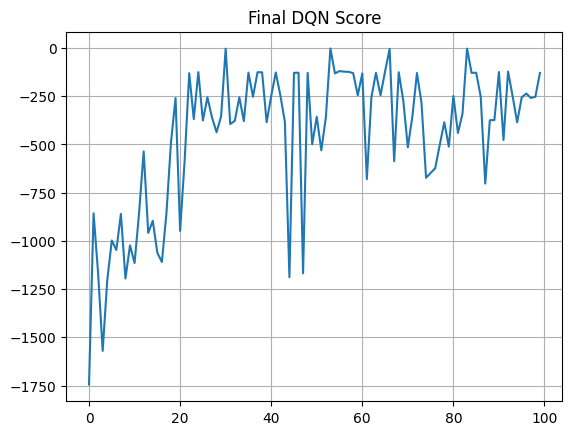

In [10]:
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    action_size = 27

    agent = Agent(state_size, action_size, gamma_epoch=15.5)

    EPOCHS = 100
    score_list = []

    for EP in range(EPOCHS):
        state, info = env.reset()
        score = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action, action_index = agent.select_action(state_tensor)
            next_state, reward, done, truncated, _ = env.step([action])
            if done or truncated:
                done = True
            agent.store_experience(state, action_index, reward, next_state, done)
            agent.train_agent()
            state = next_state
            score += reward

        score_list.append(score)
        print(f"Episodes {EP + 1}/{EPOCHS}, Score: {score}, Epsilon: {agent.epsilon}")

    plt.plot(score_list)
    plt.grid(True)
    plt.title("Final DQN Score")
    plt.savefig('Final dqn_plot).png')
    plt.show()

In [11]:
def save_model(agent, filename="dqn_model.pth"):
    checkpoint = {
        'model_state_dict': agent.model.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'replay_buffer': agent.memory.buffer,
        'epsilon': agent.epsilon
    }
    torch.save(checkpoint, filename)
    print("Model saved!")

def load_model(agent, filename="dqn_model.pth"):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        agent.model.load_state_dict(checkpoint['model_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        agent.memory.buffer = checkpoint['replay_buffer']
        agent.epsilon = checkpoint['epsilon']
        print("Model loaded!")
    else:
        print("No saved model found.")

In [12]:
save_model(agent)

Model saved!


In [70]:
def evaluate_agent(env, agent, n_episodes=10):
    scores = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        score = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action, _ = agent.select_action(state_tensor)  # Exploit the learned policy
            next_state, reward, done, truncated, _ = env.step([action])
            if done or truncated:
                done = True
            state = next_state
            score += reward

        scores.append(score)

    return scores

# Load the model and evaluate
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    action_size = 27

    agent = Agent(state_size, action_size, gamma_epoch=15.5)
    load_model(agent)

    # Evaluate the agent
    scores = evaluate_agent(env, agent, n_episodes=100)
    average_score = sum(scores) / len(scores)
    print(f"Average Score over 100 episodes: {average_score}")


Model loaded!
Average Score over 100 episodes: -206.14724172801326


In [71]:
if __name__ == "__main__":
    env = gym.make('Pendulum-v1', render_mode='human')
    state_size = env.observation_space.shape[0]
    action_size = 27

    agent = Agent(state_size, action_size, gamma_epoch=15.5)
    load_model(agent)

    # Evaluate the agent
    evaluate_agent(env, agent, n_episodes=5)
    env.close()

Model loaded!
